In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import time
import random
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
from tensorboard import notebook
from model import Model
from tf_sde_euler import tf_sde_euler
%load_ext tensorboard

import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

np.random.seed(1)

Tensorflow version: 2.10.0


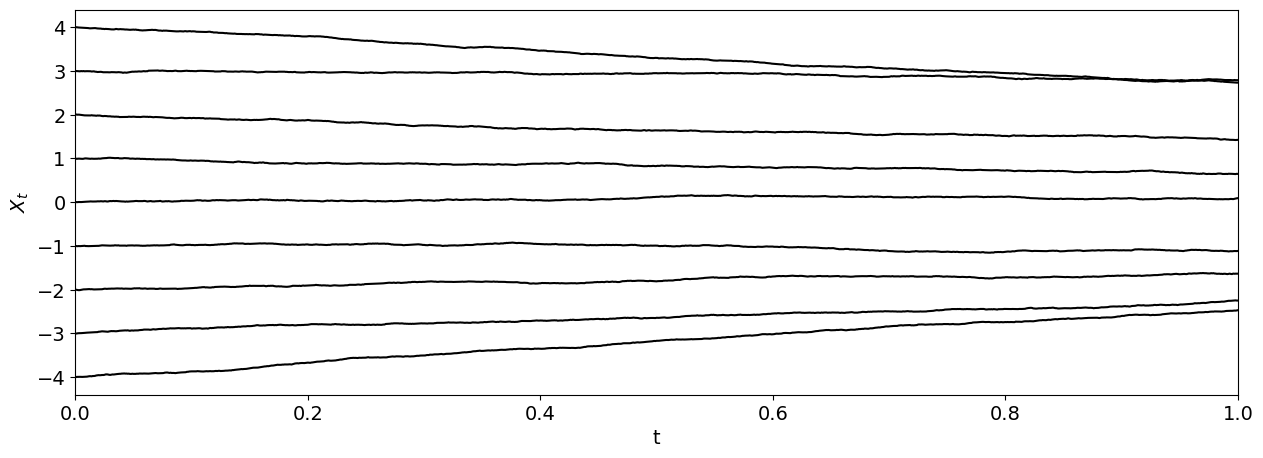

tf.Tensor(
[[1. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1. 1.]], shape=(9, 9), dtype=float32)


In [28]:
dt = 1e-3
N = 9
alpha = 1
sig = 0.1

# Set up random adjacency matrix
baseline = Model(N=N, dt=dt, alpha=alpha, sig=sig)
obj = baseline
obj.x0 = np.linspace(-4, 4, N)
obj.erdosrenyi(0.3)
obj.network()
obj.simulate()
obj.plot_trajectory(opt=False)

target_path = obj.x
target_A = tf.cast(obj.A, dtype=tf.float32)
print(target_A)

In [29]:
# Training data parameters
time_window = 2
sample_size = target_path.shape[0]//2

In [30]:
@tf.function
def simulate(A):

    drift = lambda x: (alpha / N) * (tf.tensordot(A, x, axes=1) - x*tf.reduce_sum(A, axis=1))
    diffusion = lambda x: sig

    # Generate rolling windows
    indices = tf.range(sample_size)[:, None] + tf.range(time_window)

    target_data = tf.gather(target_path, indices)
    target_data = tf.cast(target_data, dtype = tf.float32)
    init_data = target_data[:, 0, :]

    # Simulate training data from initial data
    train_data = tf.map_fn(fn=lambda x0: tf_sde_euler(drift, diffusion, (time_window-1)*dt, dt, x0), 
                           elems=init_data)

    return train_data, target_data

Loss: 0.044098563492298126


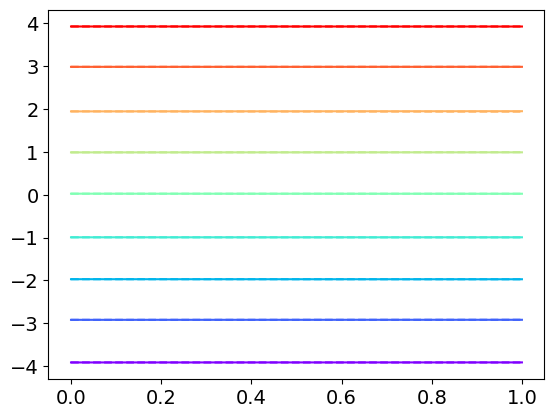

In [31]:
train_data, target_data = simulate(target_A)
print(f"Loss: {tf.nn.l2_loss(train_data - target_data)}")

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.rainbow(np.linspace(0, 1, N))) 

ridx = np.random.randint(0, sample_size)

plt.plot(train_data[ridx], linestyle='dashed')
plt.plot(target_data[ridx])
plt.show()

In [32]:
# Neural network architecture parameters
num_input_nodes = time_window*N # flattened time-window*N for target data
num_output_nodes = N**2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='ReLU', use_bias=False, input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(20, activation='ReLU', use_bias=False),
    # tf.keras.layers.Dense(20, activation='ReLU', use_bias=False),
    # tf.keras.layers.Dense(20, activation='ReLU', use_bias=False),
    # tf.keras.layers.Dense(20, activation='ReLU', use_bias=False),
    tf.keras.layers.Dense(num_output_nodes, activation=tf.keras.activations.sigmoid, use_bias=False)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                360       
                                                                 
 dense_7 (Dense)             (None, 20)                400       
                                                                 
 dense_8 (Dense)             (None, 81)                1620      
                                                                 
Total params: 2,380
Trainable params: 2,380
Non-trainable params: 0
_________________________________________________________________


# Training

In [33]:
# Dataset
dataset = tf.data.Dataset.from_tensor_slices(
    tf.reshape(target_data, [sample_size, num_input_nodes])
)

# Hyper-parameters
lr = 2e-3
batch_size = target_data.shape[0]

# Adam optimizer
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)
model.compile(
    optimizer,
    loss=tf.nn.l2_loss
)

In [34]:
@tf.function(jit_compile=True)
def init_train_step(target_data, prior):

    with tf.GradientTape() as tape:

        A = tf.reduce_mean(model(target_data), axis=0)
        A = tf.reshape(A, [N, N])

        # Compute loss value
        loss_value = tf.nn.l2_loss(A - prior)

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

In [35]:
def init_weights(target_data, prior, tolerance):
    "Initialise weights of neural net to output identity matrix"
    loss_value = 1
    while loss_value > tolerance:
        dataset = target_data.shuffle(len(target_data)).batch(batch_size)
        for batch in dataset:
            loss_value = init_train_step(batch, prior)

In [36]:
init_weights(dataset, tf.eye(N), 1e-3)

In [37]:
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=1e-4, amsgrad=True, jit_compile=True)

model.compile(
    optimizer,
    loss=tf.nn.l2_loss
)

In [38]:
@tf.function(jit_compile=True)
def train_step(target_data):

    with tf.GradientTape() as tape:

        A = tf.reshape(
            tf.reduce_mean(model(target_data), axis=0),
            [N, N]
            )
        # Restrict matrix to be symmetric and have ones on diagonal
        A = tf.eye(N) + tf.linalg.band_part(A, 0, -1) + tf.linalg.band_part(tf.transpose(A), -1, 0) - 2*tf.linalg.band_part(A, 0, 0)
        
        # Forward pass of the model to get training paths
        train_data, target_data = simulate(A)

        # Compute loss that aims to make simulated paths same as observed path
        loss_value = tf.nn.l2_loss(train_data - target_data)

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value, A

In [ ]:
# train_step(tf.reshape(target_data, [sample_size, num_input_nodes]))
# np.around(train_step(tf.reshape(target_data, [sample_size, num_input_nodes]))[1], decimals=2)

In [39]:
def training_algorithm(target_data, num_epochs):

    # Initialise metrics to get mean loss per epoch and episode
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()

        # Shuffle true data and batch
        train_data = target_data.shuffle(len(target_data)).batch(batch_size)

        for batch in train_data:

            # Training step
            loss_value, A = train_step(batch)      
                        
            # Update the metrics per epoch
            epoch_loss_metric.update_state(loss_value)
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()

        # Summary stats per epoch
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}: log10(loss): {tf.experimental.numpy.log10(epoch_mean_loss):.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

In [26]:
%tensorboard --logdir logs/gradient_tape --host localhost

Reusing TensorBoard on port 6006 (pid 1072), started 0:00:03 ago. (Use '!kill 1072' to kill it.)

In [40]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
desc = f'N={N},a={alpha},sig={sig}'
train_log_dir = 'logs/gradient_tape/' + current_time + '-' + desc
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
with train_summary_writer.as_default():
    training_algorithm(dataset, 10000)

Epoch 0: log10(loss): -1.32441
Epoch 100: log10(loss): -1.33375
Epoch 200: log10(loss): -1.33755
Epoch 300: log10(loss): -1.34393
Epoch 400: log10(loss): -1.34898
Epoch 500: log10(loss): -1.34450
Epoch 600: log10(loss): -1.35110
Epoch 700: log10(loss): -1.34159
Epoch 800: log10(loss): -1.34484
Epoch 900: log10(loss): -1.34077
Epoch 1000: log10(loss): -1.34295
Epoch 1100: log10(loss): -1.34512
Epoch 1200: log10(loss): -1.34175
Epoch 1300: log10(loss): -1.34656
Epoch 1400: log10(loss): -1.35199
Epoch 1500: log10(loss): -1.35276
Epoch 1600: log10(loss): -1.34416
Epoch 1700: log10(loss): -1.34378
Epoch 1800: log10(loss): -1.34745
Epoch 1900: log10(loss): -1.35111
Epoch 2000: log10(loss): -1.33140
Epoch 2100: log10(loss): -1.33994
Epoch 2200: log10(loss): -1.35473
Epoch 2300: log10(loss): -1.34865
Epoch 2400: log10(loss): -1.34394
Epoch 2500: log10(loss): -1.34377
Epoch 2600: log10(loss): -1.33915
Epoch 2700: log10(loss): -1.36124
Epoch 2800: log10(loss): -1.34572
Epoch 2900: log10(loss): -

In [45]:
# Save model weights
model.save_weights(f'./weights/' + desc)

In [15]:
model.load_weights('./weights/N=9,a=1,sig=0.1')

In [46]:
A_pred = tf.reshape(tf.reduce_mean(model(tf.reshape(target_data, [sample_size, num_input_nodes])), axis=0), [N, N])
A_pred = tf.eye(N) + tf.linalg.band_part(A_pred, 0, -1) + tf.linalg.band_part(tf.transpose(A_pred), -1, 0) - 2*tf.linalg.band_part(A_pred, 0, 0)
print(np.around(A_pred, decimals=2))
print(target_A)
# Deviation of predicted adjacency matrix against actual
np.around(tf.nn.l2_loss(A_pred - obj.A), decimals=3)

[[1.   0.02 0.23 0.35 0.58 0.02 0.76 0.17 0.79]
 [0.02 1.   0.9  0.22 0.03 0.48 0.29 0.   0.26]
 [0.23 0.9  1.   0.67 0.01 0.6  0.14 0.01 0.24]
 [0.35 0.22 0.67 1.   0.   0.18 0.05 0.   0.27]
 [0.58 0.03 0.01 0.   1.   0.89 0.47 0.09 0.55]
 [0.02 0.48 0.6  0.18 0.89 1.   0.25 0.   0.29]
 [0.76 0.29 0.14 0.05 0.47 0.25 1.   0.02 0.04]
 [0.17 0.   0.01 0.   0.09 0.   0.02 1.   0.03]
 [0.79 0.26 0.24 0.27 0.55 0.29 0.04 0.03 1.  ]]
tf.Tensor(
[[1. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1. 1.]], shape=(9, 9), dtype=float32)


9.72

In [42]:
train_data, target_data = simulate(A_pred)
print(f"Loss: {tf.nn.l2_loss(train_data - target_data)}")

Loss: 0.044279664754867554


In [43]:
predict = Model(N=N, dt=dt, alpha=alpha, sig=sig)
predict.x0 = obj.x0
predict.A = A_pred.numpy()
predict.network()
predict.simulate()

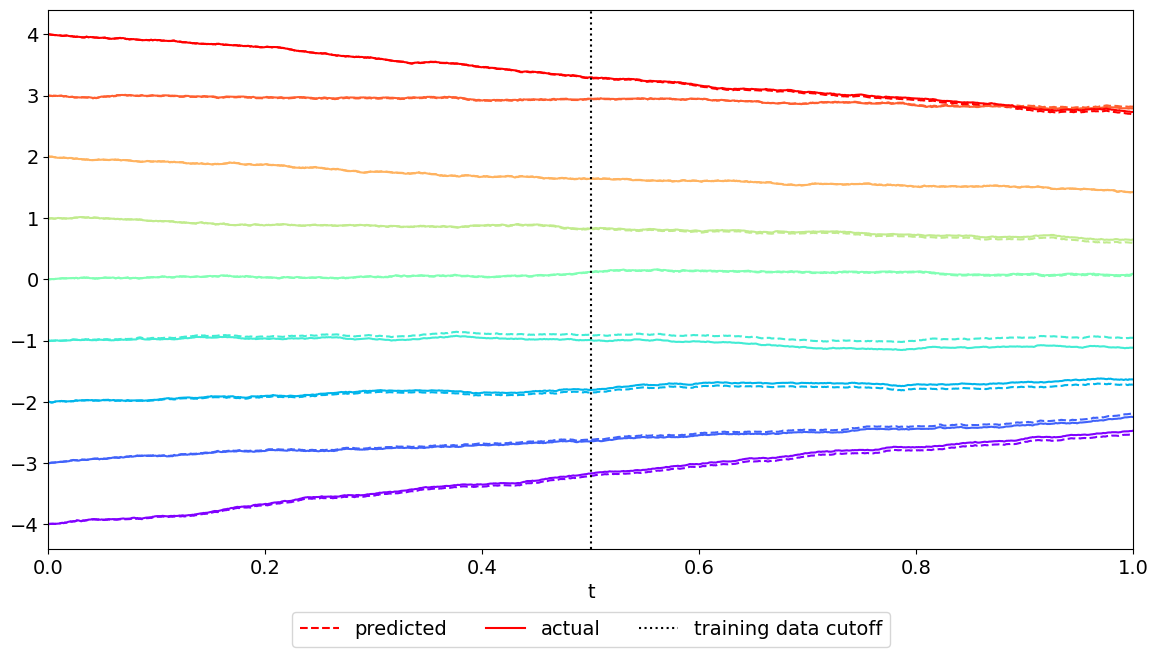

In [44]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14, 7))

plt.xlabel("t")
plt.plot(predict.t, predict.x, linestyle='dashed', label='predicted')
plt.plot(obj.t, obj.x, label='actual')
plt.axvline(x=0.5, color='black', linestyle='dotted', label="training data cutoff")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.xlim([0, 1])
plt.show()